In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 9)})
sns.set(font_scale = 1.5)

In [22]:
country = "australia"

#Constante ip

IP_PER_COUNTRY = {
    "usa": "128.112.0.0",
    "australia": "130.130.39.1",
    "china": "101.4.0.1",
    "noruega": "129.240.118.130",
    "israel": "132.66.11.168"
}

destiny_ip = IP_PER_COUNTRY[country]

#Dataframes

for csv_path in os.listdir("../data/"):
    if destiny_ip in csv_path:
        if "(all ips)" in csv_path:
            complete_data_path = csv_path
        else:
            mean_data_path = csv_path

dict_capturas = dict({country: f'../data/{complete_data_path}',
                      f"{country}_mean": f'../data/{mean_data_path}'})

for captura in dict_capturas.keys():
    dict_capturas[captura] = pd.read_csv(dict_capturas[captura])
    dict_capturas[captura].name = captura

df_tll_jumps = dict_capturas[country]
df_tll_jumps_mean = dict_capturas[f"{country}_mean"]

def most_frequent(List):
    return max(set(List), key = List.count)

In [23]:
df_tll_jumps

,ttl,ip,rtt
0,1,192.168.0.1,112.776279
1,1,192.168.0.1,55.191040
2,1,192.168.0.1,63.165665
3,1,192.168.0.1,59.157848
4,1,192.168.0.1,55.094242
...,...,...,...
611,30,130.130.39.1,347.414732
612,30,130.130.39.1,351.170778
613,30,130.130.39.1,354.884148
614,30,130.130.39.1,366.743565


# Camino de ip's

In [24]:
# Diccionario que en cada entrada es un ttl, y en cada una hay una lista con las ips
# que aparecieron en ese salto
dict_ips_for_every_ttl = dict()
dict_ips_for_every_ttl['ttl1'] = []

# Esto lo hago para poder iterar el df
df_tll_jumps = df_tll_jumps.reset_index()

row_ttl = 1
for index, row in df_tll_jumps.iterrows():
    if (row['ttl'] == row_ttl):
        dict_ips_for_every_ttl['ttl'+str(row_ttl)].append(row['ip'])
    else:
        row_ttl = row['ttl']
        dict_ips_for_every_ttl['ttl'+str(row_ttl)] = []
        dict_ips_for_every_ttl['ttl'+str(row_ttl)].append(row['ip'])

most_frequent_ip = dict()
ttl_anterior = 'ttl1'
for ttl in dict_ips_for_every_ttl.keys():
    if (most_frequent(dict_ips_for_every_ttl[ttl]) == most_frequent(dict_ips_for_every_ttl[ttl_anterior]) and most_frequent(dict_ips_for_every_ttl[ttl]) == destiny_ip):
        break    
    most_frequent_ip[ttl] = most_frequent(dict_ips_for_every_ttl[ttl])
    ttl_anterior = ttl

# most_frequent_ip es un diccionario que la clave tiene el ttl correspondiente, y en el valor la ip
# que más apareció para ese ttl

# Dataframe nuevo

In [25]:
dict_ttl_tiempos = dict()

row_ttl = 0
for index, row in df_tll_jumps.iterrows():
    if (('ttl' + str(row['ttl']) in most_frequent_ip.keys()) and row['ip'] == most_frequent_ip['ttl' + str(row['ttl'])]):
        if (row['ttl'] == row_ttl):
            dict_ttl_tiempos['ttl'+str(row_ttl)].append(row['rtt'])
        else:
            row_ttl = row['ttl']
            dict_ttl_tiempos['ttl'+str(row_ttl)] = []
            dict_ttl_tiempos['ttl'+str(row_ttl)].append(row['rtt'])

ttls = most_frequent_ip.keys()

tiempos = [np.mean(dict_ttl_tiempos[tiempo]) for tiempo in dict_ttl_tiempos.keys()]

tiempos_aux = tiempos.copy()

for i in range(1, len(tiempos)):
    jump = tiempos[i] - tiempos_aux[i-1]
    if jump < 0:
        j = 1
        while i - j > 0 and jump < 0:
            j += 1
            jump = tiempos[i] - tiempos_aux[i-j]
    tiempos[i] = max(jump, 0)

varianza_de_los_tiempos = [np.var(dict_ttl_tiempos[tiempo]) for tiempo in dict_ttl_tiempos.keys()]

df_time = pd.DataFrame(list(zip(ttls, most_frequent_ip.values(),tiempos, tiempos_aux,varianza_de_los_tiempos)),
               columns =['ttls', 'ip', 'tiempo restado', 'tiempo neto', 'varianza'])

df_time

,ttls,ip,tiempo restado,tiempo neto,varianza
0,ttl1,192.168.0.1,61.122445,61.122445,212.366432
1,ttl6,181.96.103.168,13.993235,75.115681,0.000000
2,ttl7,195.22.220.56,9.516847,70.639292,90.199850
3,ttl8,89.221.35.145,126.550357,197.189649,72.221350
4,ttl9,198.32.176.177,3.298092,200.487741,74.330771
5,ttl10,202.158.194.176,156.204391,356.692131,61.630631
6,ttl11,113.197.15.146,3.842251,360.534382,142.564491
7,ttl12,113.197.15.12,1.627541,358.319672,132.783048
8,ttl13,138.44.5.111,4.744522,363.064194,109.010086
9,ttl14,203.10.91.69,1.098262,357.790393,122.331140


# Gráficos

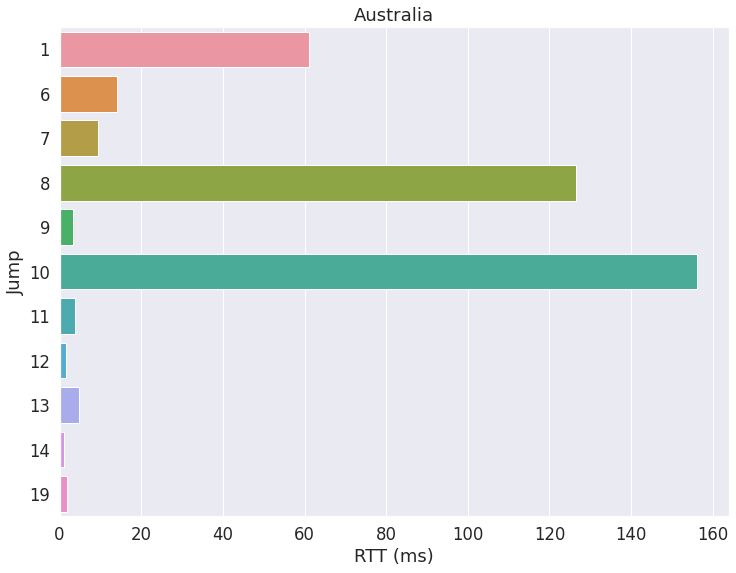

In [26]:


df_time["jump"] = df_time["ttls"].str[3:]
ax = sns.barplot(
    x= df_time['tiempo restado'], 
    y= df_time['jump'],
    estimator=sum,
    ci=None,
    orient = 'h'
)
ax.set_xlabel("RTT (ms)")
ax.set_ylabel("Jump")
ax.set_title(country.capitalize())
fig = ax.get_figure()
fig.savefig(f"./graficos/ttl_hist_{country}.png", dpi=200)

In [27]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import requests

locations = []

for ip in most_frequent_ip.values():
    response = requests.get("http://ip-api.com/json/"+ip).json()
    if (response['status'] == 'success'):
        locations.append([response['lat'], response['lon']])
    else:
        locations.append([0, 0])


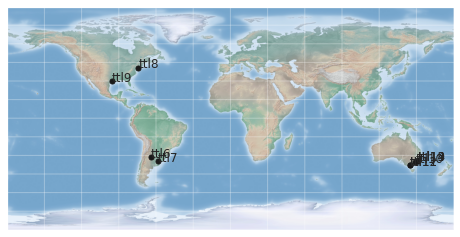

In [29]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)

# Map (long, lat) to (x, y) for plotting
for i in range(len(df_time)):
    if ((locations[i][0] != 0) and (locations[i][1] != 0)):
        x = locations[i][1]
        y = locations[i][0]
        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, df_time.iloc[i].ttls, fontsize=12);

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import requests

locations_with_ttl = []

for ttl, ip in most_frequent_ip.items():
    response = requests.get("http://ip-api.com/json/"+ip).json()
    if (response['status'] == 'success'):
        locations_with_ttl.append([ttl, response['lat'], response['lon']])

df_ubication = pd.DataFrame(locations_with_ttl, columns=["ttl", "Latitude", "Longitude"])
df_ubication

,ttl,Latitude,Longitude
0,ttl6,-31.3183,-64.1625
1,ttl7,-34.6037,-58.3816
2,ttl8,40.7357,-74.1724
3,ttl9,29.7281,-95.4451
4,ttl10,-35.2828,149.1283
5,ttl11,-37.8159,144.9669
6,ttl12,-37.8159,144.9669
7,ttl13,-33.8715,151.2006
8,ttl14,-34.4272,150.8942
9,ttl19,-34.4081,150.8790


In [31]:
import plotly.express as px

fig = px.line_geo(df_ubication, 
                     # longitude is taken from the df["lon"] columns and latitude from df["lat"]
                     lon="Longitude", 
                     lat="Latitude", 
                     # choose the map chart's projection
                     projection="natural earth",
                     markers=True,
                     hover_name = "ttl",
                     title=country.capitalize()
                     )
fig.update_traces(marker=dict(size=5, color="blue"))
fig.update_geos(fitbounds="locations", showcountries = True)
fig.write_image(f"./graficos/worldmap_{country}.png", engine="kaleido", scale=4)
fig.show()

### Punto Opcional

In [32]:
import scipy.stats

def get_thompson_for_n(n):
    alpha = 0.05
    qt = scipy.stats.t.ppf(q = 1 - alpha/2, df = n-2)
    thompson = (qt * (n - 1)) / (np.sqrt(n) * np.sqrt(n - 2 + qt**2))
    return thompson

def find_outliers(df):
    df = df.copy()
    df["outlier"] = False
    df["rtt_deviations"] = 0
    
    while len(df[df["outlier"] == False]) != 0:
        df_without_outliers = df[df["outlier"] == False]
        rtts = df_without_outliers["tiempo restado"]
        df_without_outliers["rtt_deviations"] = abs(rtts - rtts.mean())
        std = rtts.std()
        thompson = get_thompson_for_n(len(df_without_outliers))
        if max(df_without_outliers["rtt_deviations"]) > thompson * std:
            ttl_outlier = df_without_outliers.loc[df_without_outliers["rtt_deviations"].idxmax()]["ttls"]
            #df.at[df.loc[df["ttls"] == ttl_outlier].index[0], "outlier"] = True
            df.loc[df["ttls"] == str(ttl_outlier), "outlier"] = True
        else:
            break
    
    df.drop("rtt_deviations", axis=1, inplace=True)
    return df

df_with_outliers = find_outliers(df_time)
print(df_with_outliers)

     ttls               ip  tiempo restado  tiempo neto    varianza jump  \
0    ttl1      192.168.0.1       61.122445    61.122445  212.366432    1   
1    ttl6   181.96.103.168       13.993235    75.115681    0.000000    6   
2    ttl7    195.22.220.56        9.516847    70.639292   90.199850    7   
3    ttl8    89.221.35.145      126.550357   197.189649   72.221350    8   
4    ttl9   198.32.176.177        3.298092   200.487741   74.330771    9   
5   ttl10  202.158.194.176      156.204391   356.692131   61.630631   10   
6   ttl11   113.197.15.146        3.842251   360.534382  142.564491   11   
7   ttl12    113.197.15.12        1.627541   358.319672  132.783048   12   
8   ttl13     138.44.5.111        4.744522   363.064194  109.010086   13   
9   ttl14     203.10.91.69        1.098262   357.790393  122.331140   14   
10  ttl19     130.130.39.1        1.701090   359.491483  121.597093   19   

    outlier  
0      True  
1      True  
2      True  
3      True  
4     False  
5  

/tmp/ipykernel_30971/75297637.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



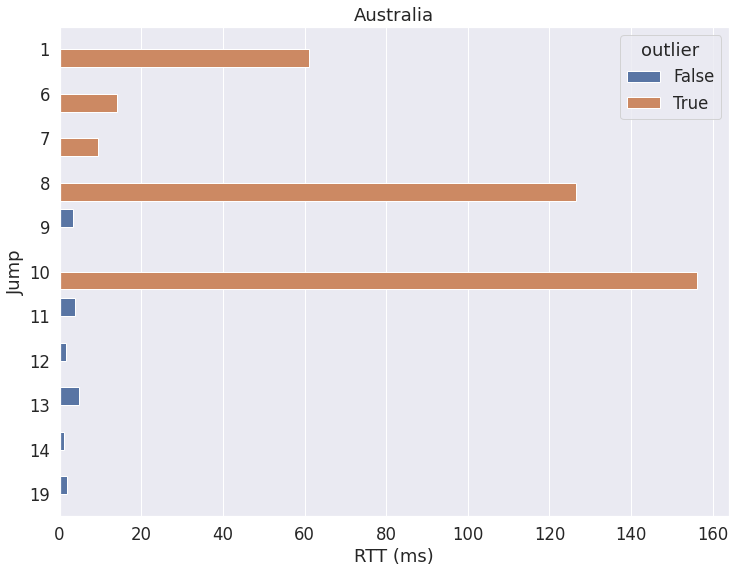

In [33]:
df_with_outliers["jump"] = df_with_outliers["ttls"].str[3:]
ax = sns.barplot(
    x= df_with_outliers['tiempo restado'], 
    y= df_with_outliers['jump'],
    estimator=sum,
    ci=None,
    orient = 'h',
    hue=df_with_outliers['outlier']
)
ax.set_xlabel("RTT (ms)")
ax.set_ylabel("Jump")
ax.set_title(country.capitalize())
fig = ax.get_figure()
fig.savefig(f"./graficos/ttl_hist_outliers_{country}.png", dpi=200)

In [34]:
df_ubication_with_outlier = df_ubication.merge(df_with_outliers[["ttls", "outlier"]], left_on="ttl", right_on="ttls")
df_ubication_with_outlier

,ttl,Latitude,Longitude,ttls,outlier
0,ttl6,-31.3183,-64.1625,ttl6,True
1,ttl7,-34.6037,-58.3816,ttl7,True
2,ttl8,40.7357,-74.1724,ttl8,True
3,ttl9,29.7281,-95.4451,ttl9,False
4,ttl10,-35.2828,149.1283,ttl10,True
5,ttl11,-37.8159,144.9669,ttl11,False
6,ttl12,-37.8159,144.9669,ttl12,False
7,ttl13,-33.8715,151.2006,ttl13,False
8,ttl14,-34.4272,150.8942,ttl14,False
9,ttl19,-34.4081,150.8790,ttl19,False


In [35]:
df_ubication_with_outlier["color"] = "blue"
df_ubication_with_outlier["markersize"] = 7
df_ubication_with_outlier["markersymbol"] = "circle"
def format_outliers(row):
    if row["outlier"]:
        row["color"] = "red"
        row["markersize"] = 10
        row["markersymbol"] = "diamond"
    return row
df_ubication_with_outlier = df_ubication_with_outlier.apply(format_outliers, axis=1)

In [36]:
import plotly.express as px

fig = px.line_geo(df_ubication, 
                     # longitude is taken from the df["lon"] columns and latitude from df["lat"]
                     lon="Longitude", 
                     lat="Latitude", 
                     # choose the map chart's projection
                     projection="natural earth",
                     markers=True,
                     hover_name = "ttl",
                     title=country.capitalize()
                     )
fig.update_traces(marker=dict(symbol = df_ubication_with_outlier["markersymbol"], size=df_ubication_with_outlier["markersize"], color=df_ubication_with_outlier["color"]))
fig.update_geos(fitbounds="locations", showcountries = True)
fig.write_image(f"./graficos/worldmap_outliers_{country}.png", engine="kaleido", scale=4)
fig.show()